In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import pandas as pd

### 25 Neurons using concave down exponential function

test accuracy ~ 92-93%

EIT curves are normalized

In [ ]:
# Provided parameter values
a = np.array([1.44459561, 1.4909716, 1.29900401, 1.59823275, 1.95377401,
              1.29692538, 1.3884494, 1.41366705, 1.4720679, 1.94549286,
              1.42256119, 1.35419586, 1.0655931, 1.4807465, 3.57915218,
              1.28707514, 1.29840168, 1.42614346, 2.301248, 1.82484445,
              1.37406175, 1.32049406, 1.48991211, 2.36839102, 2.57548982])
OD = np.array([10.62209668, 5.29927502, 5.24461367, 3.95714724, 3.53289089,
               4.90284341, 4.77882344, 4.21487304, 2.88143791, 3.68379522,
               7.11055405, 6.37264251, 5.52053175, 4.6822641, 3.91513311,
               3.79516812, 16.75179172, 4.82518489, 3.90599822, 4.43170833,
               4.68538009, 5.17359904, 5.77046094, 4.69307385, 4.32273257])
g = np.array([1018.98154797, 2459.73045748, 1571.1443399, 4717.39214842,
              7757.19215507, 1678.80384039, 2371.79623817, 2763.04246768,
              5398.06831678, 6639.08957198, 1498.46771748, 1437.98348092,
              896.57655106, 2596.58011685, 15084.55697028, 2336.91028423,
              456.33896778, 2464.47850684, 8199.06494407, 4530.89552788,
              2122.01729478, 1659.39463412, 2229.42490177, 6774.64313489,
              8393.47117689])

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Parameter(torch.full((25, 144), 0.1))
        self.fc2 = nn.Parameter(torch.rand(10, 25) / 200)
        #self.dropout = nn.Dropout(0.5)
        self.a_ = torch.tensor(a, dtype=torch.float32)
        self.OD = torch.tensor(OD, dtype=torch.float32)
        self.g = torch.tensor(g, dtype=torch.float32)

    def forward(self, x):
        x = x.view(-1, 144)
        x = F.linear(x, abs(self.fc1))
        #x = self.dropout(x)
        x = self.a_ * torch.exp(-self.OD * self.g / (x * 12800 + self.g))
        #x = self.dropout(x)
        out = F.linear(x, abs(self.fc2))
        return out

def train(model, device, train_loader, optimizer):
    model.train()
    correct = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_accuracy

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

def val(model, device, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    val_loss /= len(val_loader.dataset)
    val_accuracy = 100. * correct / len(val_loader.dataset)
    return val_loss, val_accuracy

def main():
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    dataset1 = datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.Resize(12),
                           transforms.ToTensor(),
                        ]))
    train_size = int(0.75 * len(dataset1))
    val_size = int(0.10 * len(dataset1))
    test_size = len(dataset1) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset1, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False)
    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

    epochs = 50
    train_accuracies = []
    test_accuracies = []
    for epoch in range(1, epochs + 1):
        train_accuracy = train(model, device, train_loader, optimizer)
        test_loss, test_accuracy = test(model, device, test_loader)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        print(f'Epoch {epoch}: Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

    # Plotting the training and testing accuracies
    plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, epochs + 1), test_accuracies, label='Testing Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Testing Accuracy')
    plt.legend()
    plt.show()

    print("Final Weight Matrix (fc1):")
    print(model.fc1.data)
    print("Final Weight Matrix (fc2):")
    print(model.fc2.data)   

if __name__ == '__main__':
    main()

### 25 Neurons using concave down exponential fucntion and fixed W1 matrix

Accuracy plattued at ~ 20-21%

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np

# Provided parameter values
a = np.array([1.44459561, 1.4909716, 1.29900401, 1.59823275, 1.95377401,
              1.29692538, 1.3884494, 1.41366705, 1.4720679, 1.94549286,
              1.42256119, 1.35419586, 1.0655931, 1.4807465, 3.57915218,
              1.28707514, 1.29840168, 1.42614346, 2.301248, 1.82484445,
              1.37406175, 1.32049406, 1.48991211, 2.36839102, 2.57548982])
OD = np.array([10.62209668, 5.29927502, 5.24461367, 3.95714724, 3.53289089,
               4.90284341, 4.77882344, 4.21487304, 2.88143791, 3.68379522,
               7.11055405, 6.37264251, 5.52053175, 4.6822641, 3.91513311,
               3.79516812, 16.75179172, 4.82518489, 3.90599822, 4.43170833,
               4.68538009, 5.17359904, 5.77046094, 4.69307385, 4.32273257])
g = np.array([1018.98154797, 2459.73045748, 1571.1443399, 4717.39214842,
              7757.19215507, 1678.80384039, 2371.79623817, 2763.04246768,
              5398.06831678, 6639.08957198, 1498.46771748, 1437.98348092,
              896.57655106, 2596.58011685, 15084.55697028, 2336.91028423,
              456.33896778, 2464.47850684, 8199.06494407, 4530.89552788,
              2122.01729478, 1659.39463412, 2229.42490177, 6774.64313489,
              8393.47117689])

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Fix the value of the first linear layer with a uniform distribution
        self.fc1 = torch.tensor(torch.full((25, 144), 0.001)) 
        self.fc2 = nn.Parameter(torch.rand(10, 25) / 200)
        #self.dropout = nn.Dropout(0.5)
        self.a_ = torch.tensor(a, dtype=torch.float32)
        self.OD = torch.tensor(OD, dtype=torch.float32)
        self.g = torch.tensor(g, dtype=torch.float32)

    def forward(self, x):
        x = x.view(-1, 144)
        x = F.linear(x, abs(self.fc1))
        #x = self.dropout(x)
        x = self.a_ * torch.exp(-self.OD * self.g / (x * 12800 + self.g))
        #x = self.dropout(x)
        out = F.linear(x, abs(self.fc2))
        return out

def main():
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    dataset1 = datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.Resize(12),
                           transforms.ToTensor(),
                        ]))
    train_size = int(0.75 * len(dataset1))
    val_size = int(0.10 * len(dataset1))
    test_size = len(dataset1) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset1, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False)
    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

    epochs = 30
    train_accuracies = []
    test_accuracies = []
    for epoch in range(1, epochs + 1):
        train_accuracy = train(model, device, train_loader, optimizer)
        test_loss, test_accuracy = test(model, device, test_loader)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        print(f'Epoch {epoch}: Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

    # Plotting the training and testing accuracies
    plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, epochs + 1), test_accuracies, label='Testing Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Testing Accuracy')
    plt.legend()
    plt.show()

    print("Final Weight Matrix (fc1):")
    print(model.fc1.data)
    print("Final Weight Matrix (fc2):")
    print(model.fc2.data)

if __name__ == '__main__':
    main()


### 25 Neurons using concave up exponential function

In [ ]:
# given curve fitted coefficients from experimental data
# the non-linear function is of the form a*np.exp(b*x) + c
# read the coefficients from the csv file with the given file path
file_path = '/Users/MacPro2021/Desktop/Quantum Game Club/AONN-1/NN/Optimized_Curve_Fitting_Parameters.csv'
# skip the first row of the csv file
list = pd.read_csv(file_path)

a = list.iloc[:, 1].to_numpy()
b = list.iloc[:, 2].to_numpy()
c = list.iloc[:, 3].to_numpy()

a = np.array(a)
b = np.array(b)
c = np.array(c)

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Parameter(torch.rand(25, 144) / 40000)
        self.fc2 = nn.Parameter(torch.rand(10, 25) / 200)
        # defining the new parameters from the csv file loaded in the cell above
        self.a = torch.tensor(a, dtype=torch.float32)
        self.b = torch.tensor(b, dtype=torch.float32)
        self.c = torch.tensor(c, dtype=torch.float32)

    def forward(self, x):
        x = x.view(-1, 144)
        x = F.linear(x, abs(self.fc1))
        #x = self.dropout(x)
        x = self.a * torch.exp(self.b * x) + self.c
        #x = self.dropout(x)
        out = F.linear(x, abs(self.fc2))
        return out

def train(model, device, train_loader, optimizer):
    model.train()
    correct = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_accuracy

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

def val(model, device, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    val_loss /= len(val_loader.dataset)
    val_accuracy = 100. * correct / len(val_loader.dataset)
    return val_loss, val_accuracy

def main():
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    dataset1 = datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.Resize(12),
                           transforms.ToTensor(),
                        ]))
    train_size = int(0.75 * len(dataset1))
    val_size = int(0.10 * len(dataset1))
    test_size = len(dataset1) - train_size - val_size
    train_dataset, val_dataset, test_dataset = random_split(dataset1, [train_size, val_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=1000, shuffle=False)
    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

    epochs = 30
    train_accuracies = []
    test_accuracies = []
    for epoch in range(1, epochs + 1):
        train_accuracy = train(model, device, train_loader, optimizer)
        test_loss, test_accuracy = test(model, device, test_loader)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        print(f'Epoch {epoch}: Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

    # Plotting the training and testing accuracies
    plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, epochs + 1), test_accuracies, label='Testing Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Testing Accuracy')
    plt.legend()
    plt.show()

    print("Final Weight Matrix (fc1):")
    print(model.fc1.data)
    print("Final Weight Matrix (fc2):")
    print(model.fc2.data)   

if __name__ == '__main__':
    main()

loss:6.575027


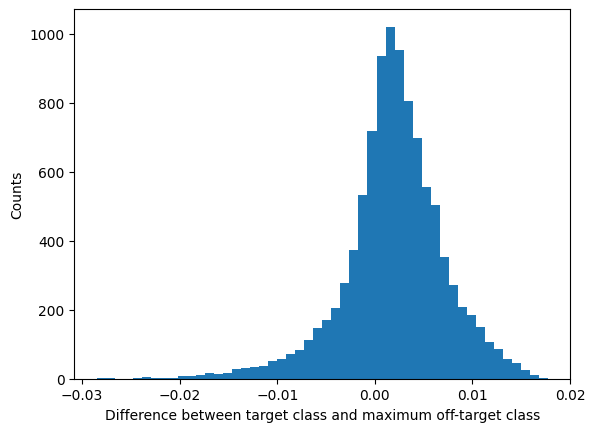


Test set: Average loss: -0.0001, Accuracy: 7118/10000 (71%)

loss:1.776850


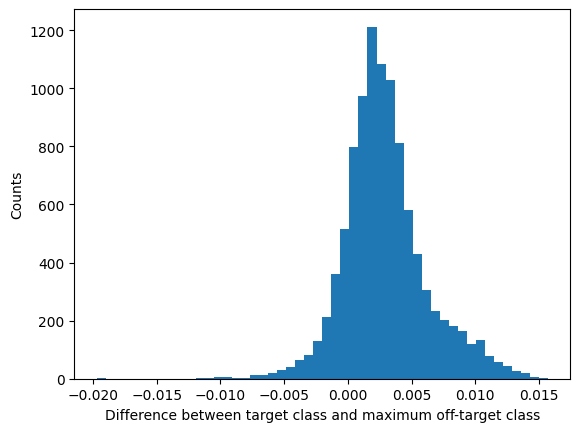


Test set: Average loss: -0.0001, Accuracy: 8621/10000 (86%)

loss:2.064517


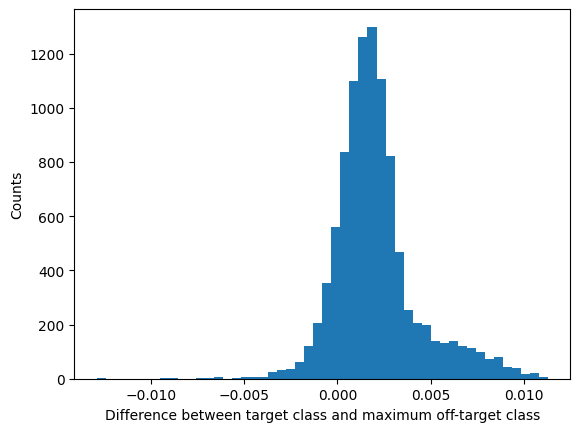


Test set: Average loss: -0.0001, Accuracy: 8790/10000 (88%)

loss:1.981133


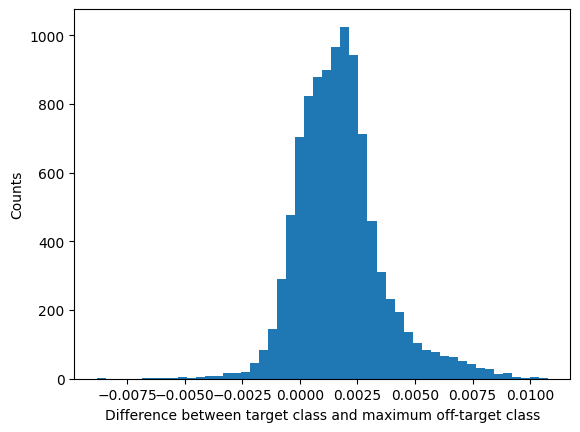


Test set: Average loss: -0.0001, Accuracy: 8550/10000 (86%)

loss:2.836445


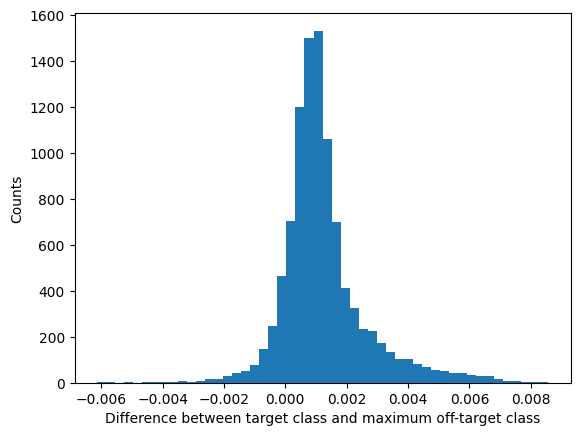


Test set: Average loss: -0.0001, Accuracy: 8963/10000 (90%)

loss:2.484146


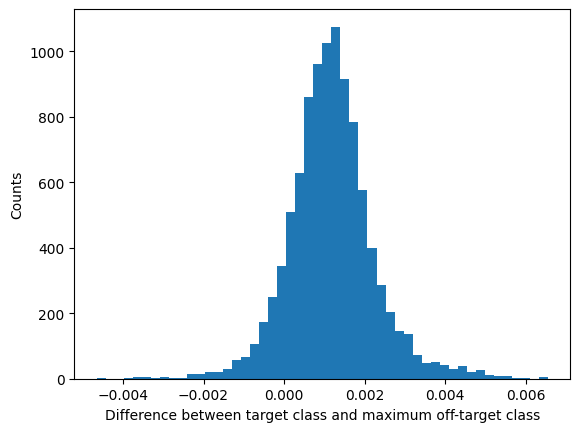


Test set: Average loss: -0.0001, Accuracy: 8977/10000 (90%)

loss:0.293484


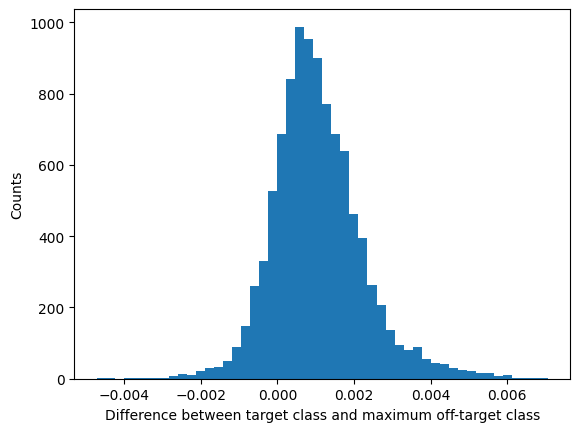


Test set: Average loss: -0.0001, Accuracy: 8467/10000 (85%)

loss:1.260163


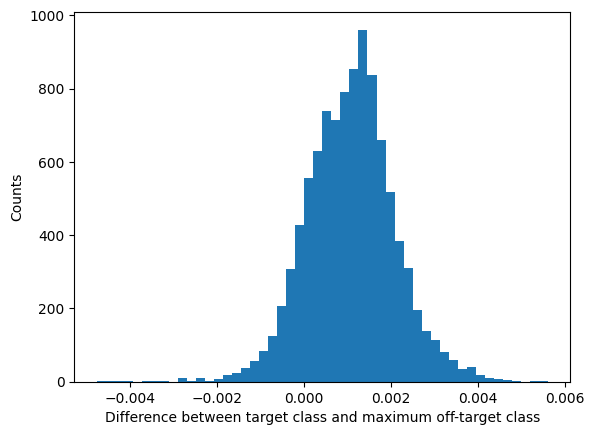


Test set: Average loss: -0.0001, Accuracy: 8684/10000 (87%)

loss:0.549537


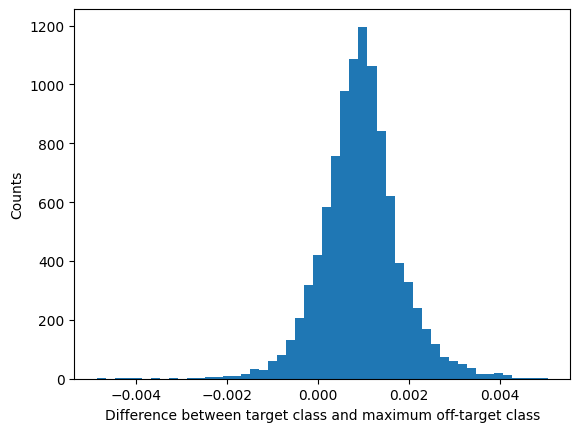


Test set: Average loss: -0.0001, Accuracy: 8856/10000 (89%)

loss:0.344918


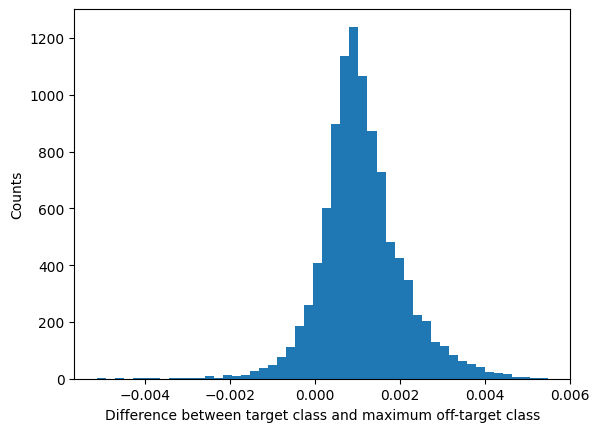


Test set: Average loss: -0.0001, Accuracy: 9131/10000 (91%)

loss:1.184190


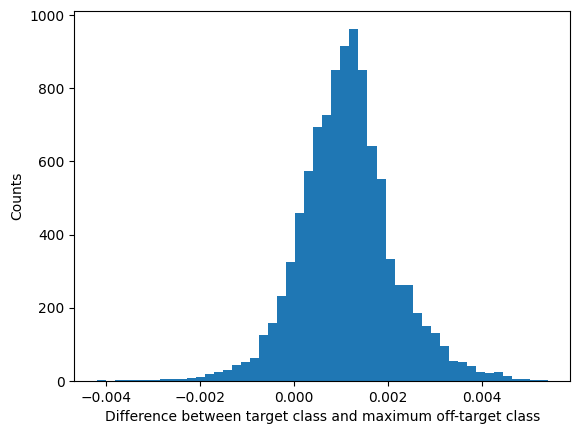


Test set: Average loss: -0.0001, Accuracy: 8937/10000 (89%)

loss:0.155514


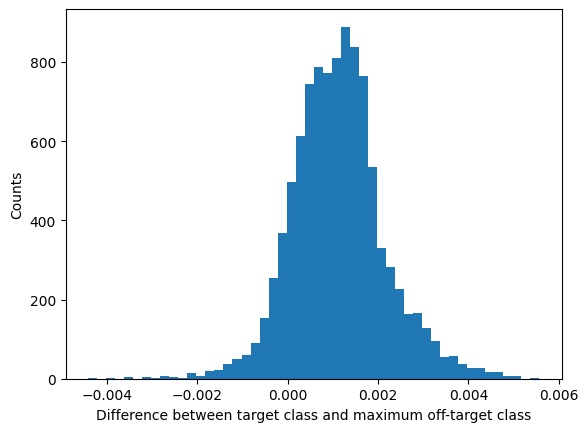


Test set: Average loss: -0.0001, Accuracy: 8850/10000 (88%)

loss:1.748335


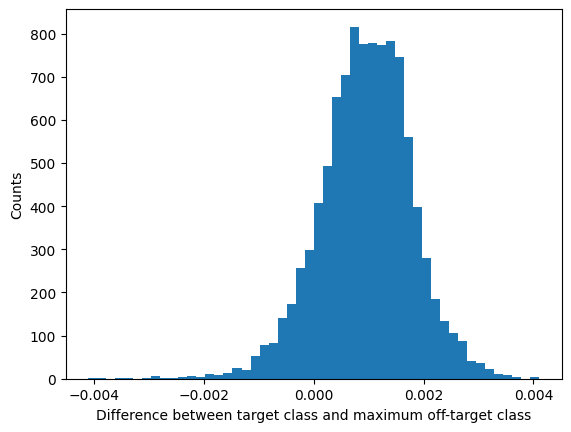


Test set: Average loss: -0.0001, Accuracy: 8811/10000 (88%)

loss:0.436076


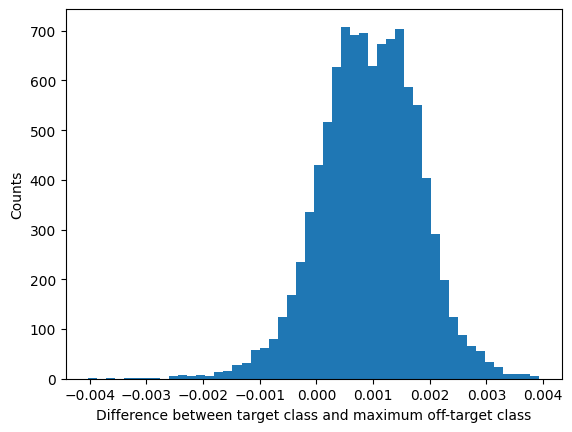


Test set: Average loss: -0.0001, Accuracy: 8705/10000 (87%)

loss:1.120614


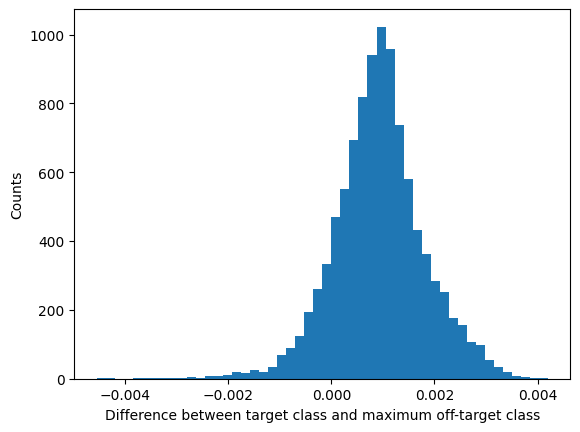


Test set: Average loss: -0.0001, Accuracy: 8770/10000 (88%)



OSError: Cannot save file into a non-existent directory: '\content\drive\My Drive'

In [2]:
# Provided parameter values
a = np.array([3534100, 3722200, 3852400, 4307000, 3657400, 3141500, 3178200,
          3960700, 3765900, 4158300, 3463600, 3263600, 4042800, 3859800,
          3263500, 3321000, 4023600, 3909900, 4442100, 3975800])

OD = np.array([2.6724, 2.6481, 2.7274, 3.0563, 3.3325, 2.9912, 2.8601, 3.3032,
          2.6161, 2.5694, 3.2993, 3.3299, 2.4537, 2.3774, 2.42, 2.9881,
          2.7565, 3.007, 3.1546, 3.063])

g = np.array([23.072, 25.567, 29.146, 24.402, 27.776, 41.254, 24.124, 20.662,
          33.321, 25.71, 28.885, 36.446, 26.033, 23.523, 40.512, 38.207,
          39.111, 29.031, 32.155, 27.549])

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Parameter(torch.rand(20, 144) / 400000)
        self.fc2 = nn.Parameter(torch.rand(10, 20) / 200)
        self.a_ = torch.tensor(a, dtype=torch.float32)
        self.gamma12_ = torch.tensor(g, dtype=torch.float32)
        self.OD = torch.tensor(OD, dtype=torch.float32)
        #self.Distr_ = torch.tensor(Distr, dtype=torch.float32).cuda()

    def forward(self, x, R):
        x = x.view(-1, 144)
        #x = x[:, 1:143] * self.Distr_.view(142)
        x = F.linear(x, abs(self.fc1))
        x = self.a_ * torch.exp(-12 * self.OD * self.gamma12_ / (x * 12800 + self.gamma12_ * 12))
        rand4 = 1 + torch.randn(10) * R
        out = F.linear(x, abs(self.fc2)) * 1
        return out

def Divi_loss(output, target):
    output = output / torch.sum(output, dim=1).view(-1, 1)
    loss = output[[np.arange(target.shape[0]), target]]
    return -torch.mean(loss)

def confusion_matrix(preds, labels):
    conf_matrix = torch.zeros(10, 10)
    for p, t in zip(preds, labels):
        conf_matrix[p, t] += 1
    return conf_matrix

def train(model, device, train_loader, optimizer):
    model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data, 0)
        loss1 = F.nll_loss(F.log_softmax(output, dim=1), target)
        loss = loss1
        loss.backward()
        optimizer.step()
    print('loss:{:.6f}'.format(loss1.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    errors = np.array([])
    ConfuMatrix = torch.zeros(10, 10)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data, 0)
            pred = output.max(1, keepdim=True)[1]
            output2 = output / torch.sum(output, dim=1).view(-1, 1)
            A1 = output2[[np.arange(target.shape[0]), target]]
            output2[[np.arange(target.shape[0]), target]] = 0
            pred2 = output2.max(1, keepdim=True)[1]
            A2 = output2[[np.arange(pred2.shape[0]), pred2.view(-1)]]
            errors = np.append(errors, (A1 / A2 - 1).cpu().detach().numpy())
            correct += pred.eq(target.view_as(pred)).sum().item()
            ConfuMatrix += confusion_matrix(pred, target)
            test_loss += Divi_loss(output, target).item()

    test_loss /= len(test_loader.dataset)

    plt.figure()
    plt.hist(errors, 50)
    plt.xlabel('Difference between target class and maximum off-target class')
    plt.ylabel('Counts')
    plt.show()
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

def save_weights_to_excel(weights, filename):
    df = pd.DataFrame(abs(weights.cpu().detach().numpy()))
    df.to_excel(filename, index=False)

def main():
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.Resize(12),
                           transforms.ToTensor(),
                       ])),
        batch_size=64, shuffle=True)

    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.Resize(12),
                           transforms.ToTensor(),
                       ])),
        batch_size=1000, shuffle=True)

    model = Net().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.000001, weight_decay=0.01)
    for epoch in range(1, 15 + 1):
        train(model, device, train_loader, optimizer)
        test(model, device, test_loader)

    # Save the weight matrices as Excel files
    save_weights_to_excel(model.fc1.data, "/content/drive/My Drive/fc1_weights.xlsx")
    save_weights_to_excel(model.fc2.data, "/content/drive/My Drive/fc2_weights.xlsx")

if __name__ == '__main__':
    main()
